In [90]:
%matplotlib inline

import sys
sys.path.append("../")
import copy

import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


from src import dataset

In [86]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
df = dataset.load_excel(excel_file)


In [87]:
df_italy = df.iloc[:, 0:1] # Arrivals to Italy
df_greek_island = df.iloc[:, 1:2] # Arrivals to Greek Island
df_mainland_greece = df.iloc[:, 2:3] # Arrivals to Mainland greece
df_fyrom = df.iloc[:, 3:4] # Arrivals to fYRoM
df_serbia = df.iloc[:, 4:5] # Arrivals to Serbia
df_croatia = df.iloc[:, 5:6] # Arrivals to Croatia
df_hungry = df.iloc[:, 6:7] # Arrivals to Hungry
df_slovenia = df.iloc[:, 7:8] # Arrivals to Slovenia
df_austria = df.iloc[:, 8:9] # Arrivals to Austria

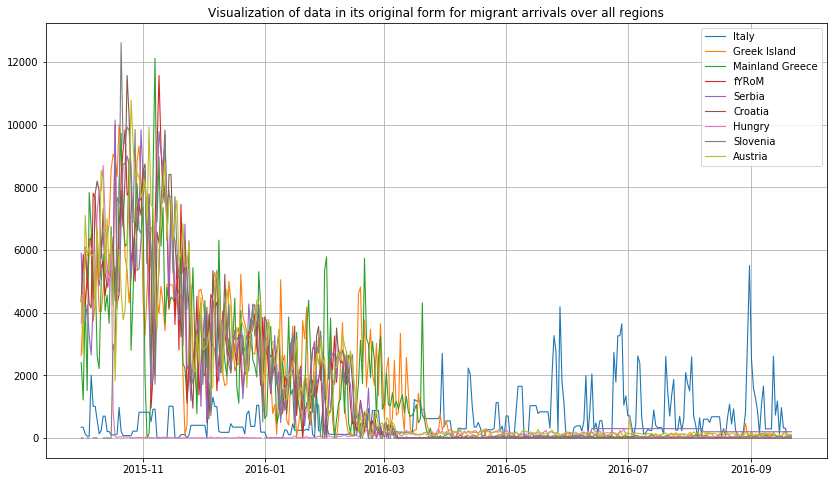

In [138]:
plt.figure(figsize=(14,8))
plt.plot(df_italy.index, df_italy.iloc[:, 0], label="Italy", linewidth=1.1)
plt.plot(df_greek_island.index, df_greek_island.iloc[:, 0], label="Greek Island", linewidth=1.1)
plt.plot(df_mainland_greece.index, df_mainland_greece.iloc[:, 0], label="Mainland Greece", linewidth=1.1)
plt.plot(df_fyrom.index, df_fyrom.iloc[:, 0], label="fYRoM", linewidth=1.1)
plt.plot(df_serbia.index, df_serbia.iloc[:, 0], label="Serbia", linewidth=1.1)
plt.plot(df_croatia.index, df_croatia.iloc[:, 0], label="Croatia", linewidth=1.1)
plt.plot(df_hungry.index, df_hungry.iloc[:, 0], label="Hungry", linewidth=1.1)
plt.plot(df_slovenia.index, df_slovenia.iloc[:, 0], label="Slovenia", linewidth=1.1)
plt.plot(df_austria.index, df_austria.iloc[:, 0], label="Austria", linewidth=1.1)
plt.legend(loc="best")
plt.title("Visualization of data in its original form for migrant arrivals over all regions")
plt.grid(True)
plt.show()

In [88]:
df = df_italy # Seriies to test

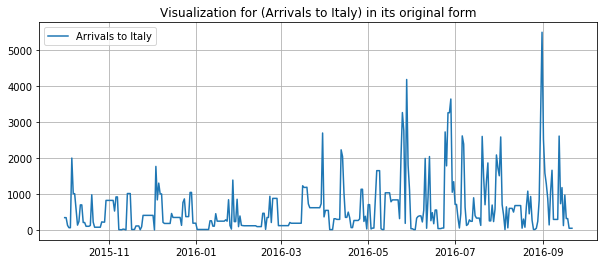

In [116]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df.iloc[:, 0], label=df.columns[0])
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [7]:
df.head()

,Departures to mainland Greece
Date,
2015-10-01,2409
2015-10-02,1215
2015-10-03,4480
2015-10-04,1513
2015-10-05,7833


In [8]:
df.tail()

,Departures to mainland Greece
Date,
2016-09-17,0
2016-09-18,61
2016-09-19,34
2016-09-20,71
2016-09-21,67


In [117]:
#Stationarity test
def test_stationarity(timeseries, win_size=3):
    #Find rolling statistics
    rolmean = timeseries.rolling(window=win_size).mean()
    rolstd = timeseries.rolling(window=win_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, linewidth=1.2,label='Original')
    mean = plt.plot(rolmean, linewidth=1.2, label='Rolling Mean')
    std = plt.plot(rolstd, linewidth=1.2, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for Stationarity (Window size %s weeks)' % win_size)
    plt.grid()
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[timeseries.columns[0]], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

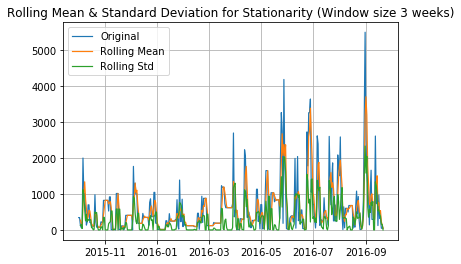

Results of Dickey-Fuller Test:
Test Statistic                -1.049297e+01
p-value                        1.134420e-18
#Lags Used                     0.000000e+00
Number of Observations Used    3.560000e+02
Critical Value (10%)          -2.571114e+00
Critical Value (5%)           -2.869693e+00
Critical Value (1%)           -3.448853e+00
dtype: float64


In [118]:
test_stationarity(df)

In [123]:
# Resample by weeks
w_df = df.resample("W").sum()
w_df = w_df.reset_index().rename(columns={'Date': 'ds', df.columns[0]: 'y'})
w_df = w_df.set_index("ds")
fill_method = "ffill"
w_df['y'] = w_df['y'].replace(to_replace=0, method=fill_method)
w_df.head()

,y
ds,
2015-10-04,876
2015-10-11,5026
2015-10-18,2116
2015-10-25,1627
2015-11-01,3205


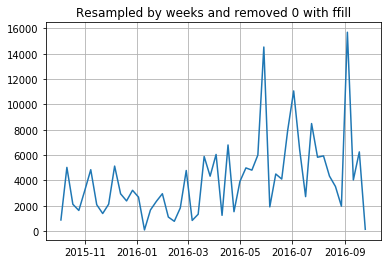

In [124]:
plt.plot(w_df.index, w_df["y"])
plt.title("Resampled by weeks and removed 0 with %s" % fill_method)
plt.grid()
plt.show()

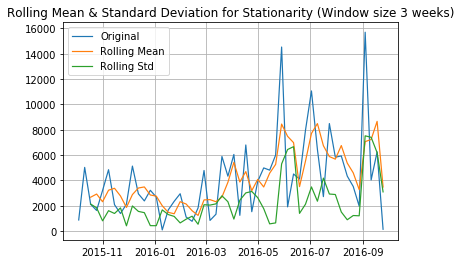

Results of Dickey-Fuller Test:
Test Statistic                 -0.808244
p-value                         0.816688
#Lags Used                      5.000000
Number of Observations Used    46.000000
Critical Value (10%)           -2.601541
Critical Value (5%)            -2.926785
Critical Value (1%)            -3.581258
dtype: float64


In [125]:
test_stationarity(w_df)

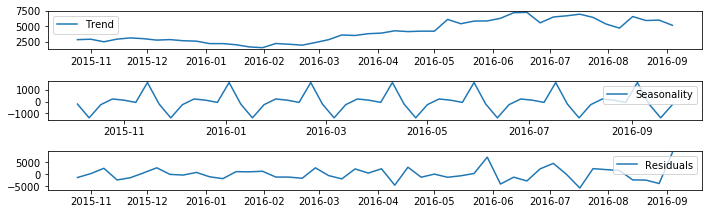

In [127]:
# Show seasonality in weekly resampled time series
plt.figure(figsize=(10,4))
decomposition = seasonal_decompose(w_df, freq=7, model="additive")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [134]:
# Transformation to log on original data
l_df = copy.deepcopy(df)
l_df[l_df.columns[0]] = l_df[l_df.columns[0]].replace(to_replace=0, method=fill_method)
l_df[l_df.columns[0]] = np.log(list(l_df[l_df.columns[0]].values))
l_df.head()

,Arrivals to Italy
Date,
2015-10-01,5.837730
2015-10-02,5.837730
2015-10-03,4.852030
2015-10-04,4.127134
2015-10-05,4.127134


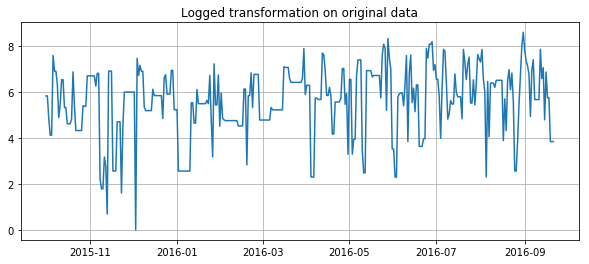

In [135]:
plt.figure(figsize=(10,4))
plt.plot(l_df)
plt.title("Logged transformation on original data")
plt.grid()
plt.show()

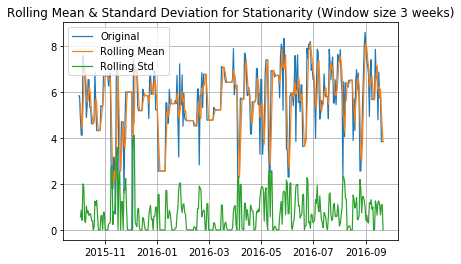

Results of Dickey-Fuller Test:
Test Statistic                -1.031730e+01
p-value                        3.073452e-18
#Lags Used                     0.000000e+00
Number of Observations Used    3.560000e+02
Critical Value (10%)          -2.571114e+00
Critical Value (5%)           -2.869693e+00
Critical Value (1%)           -3.448853e+00
dtype: float64


In [136]:
test_stationarity(l_df)

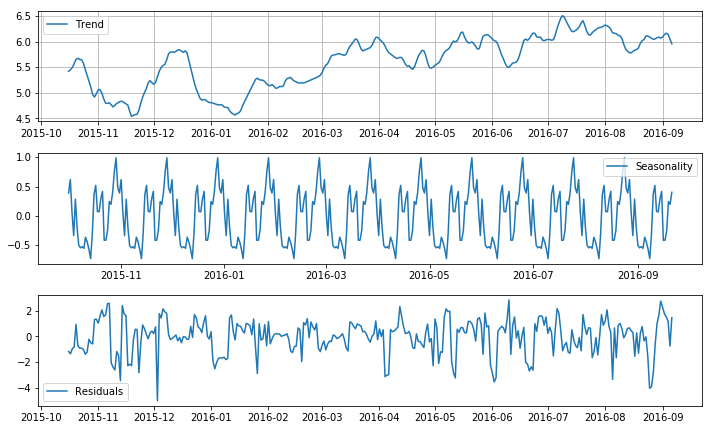

In [137]:
# Show seasonality in original logged time series
plt.figure(figsize=(10,8))
decomposition = seasonal_decompose(l_df, freq=30, model="additive")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(412)
plt.grid()
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


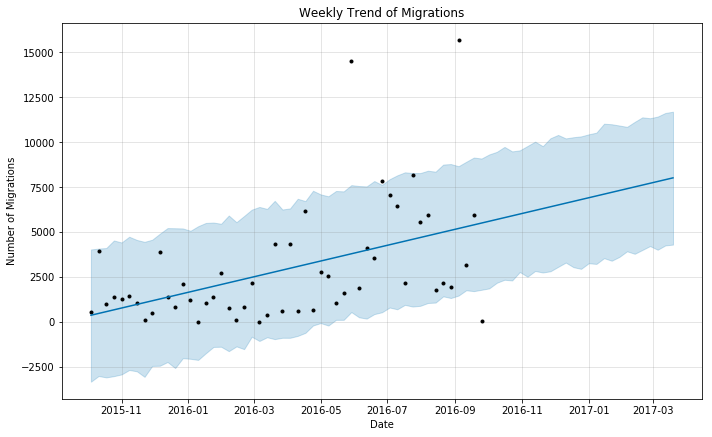

In [54]:
ph_model = fbprophet.Prophet(changepoint_prior_scale=0.14)
ph_model.fit(w_df)
ph_forecast = ph_model.make_future_dataframe(periods=25, freq='W')
ph_forecast = ph_model.predict(ph_forecast)

ph_model.plot(ph_forecast, xlabel = 'Date', ylabel = 'Number of Migrations')
plt.title('Weekly Trend of Migrations')
plt.show()

In [ ]:
# Commands to remember

df.sort_values("ColumnName").head() # Sort by column name
df.loc["2016-03-06"] # Find a value by certain index date
df.groupby(df.iloc[:, 0]).count().head() # Count all vaues in certain series
df.isnull().sum() # Sum of nulls